#### env setup

In [ ]:
# data processing pkgs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# modeling pkgs

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, auc

In [ ]:
# modeling pkgs
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC

In [ ]:
# util libs

import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
%ls

drive/  sample_data/


# read data
Dataset: [https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
# file path
file_path = "/content/drive/MyDrive/project_dsc540/data/IMDB_reviews_dataset.csv"

In [ ]:
# read data
df = pd.read_csv(file_path)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Text cleaning

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [ ]:
# remove stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_cleaned = df.copy()

In [ ]:
# convert text to lower

text_cleaned['clean_review'] = text_cleaned.review.str.lower()

Text(0.5, 1.0, 'Distribution of review length')

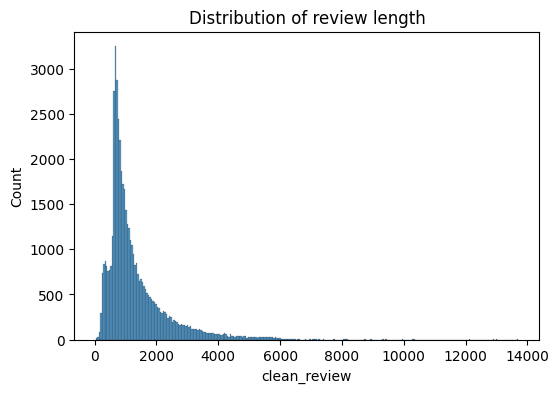

In [ ]:
# plot distribution of text length

plt.figure(figsize=(6, 4))
sns.histplot(text_cleaned.clean_review.apply(lambda x:len(x)))
plt.title("Distribution of review length")

In [ ]:
# find html like instances in text
pattern = r'<.*?>'
text_cleaned['tag_count'] = text_cleaned['clean_review'].str.count(pattern)

In [ ]:
text_cleaned.sample(10)

,review,sentiment,clean_review,tag_count
31891,"After watching Awake,I led to a conclusion:dir...",negative,"after watching awake,i led to a conclusion:dir...",0
14753,The film successfully gives a graphic portraya...,negative,the film successfully gives a graphic portraya...,6
19055,Jackie Chan movies are typical examples of how...,negative,jackie chan movies are typical examples of how...,0
5310,As a horse lover one can only appreciate this ...,positive,as a horse lover one can only appreciate this ...,0
27695,Lost has been one of the most mesmerizing and ...,positive,lost has been one of the most mesmerizing and ...,6
45402,This film was bad. I believe Elton (or is it M...,negative,this film was bad. i believe elton (or is it m...,2
11204,Lady in Cement - PI spoof with ole Blue Eyes.F...,negative,lady in cement - pi spoof with ole blue eyes.f...,0
10885,Well the story is a little hard to follow the ...,positive,well the story is a little hard to follow the ...,0
2081,I first saw this mini-series as a child and th...,positive,i first saw this mini-series as a child and th...,2
33124,"Running out of films to rent, I picked up Free...",positive,"running out of films to rent, i picked up free...",4


In [ ]:
pattern = r'<(.*?)>'

text_cleaned['tags'] = text_cleaned['clean_review'].str.extractall(pattern)[0].groupby(level=0).apply(list)

In [ ]:
exploded_df = text_cleaned.explode('tags')

# Get unique levels from the 'tags' column
unique_tags = exploded_df['tags'].unique()

In [ ]:
# create custom stop words based on HTML tags
custom_stop_words = [i for i in unique_tags if len(str(i)) < 7]

In [ ]:
custom_stop_words += [i for i in unique_tags if i not in custom_stop_words][:4]

In [ ]:
custom_stop_words += ['br']

In [ ]:
stop_words[-1]

"wouldn't"

In [ ]:
# add custom stop words to stop_words list

stop_words += custom_stop_words

In [ ]:
# tokenize data
tokenized_doc = text_cleaned['clean_review'].apply(lambda x: x.split())

In [ ]:
tokenized_doc.head()

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production., <br, /><br...
2    [i, thought, this, was, a, wonderful, way, to,...
3    [basically, there's, a, family, where, a, litt...
4    [petter, mattei's, "love, in, the, time, of, m...
Name: clean_review, dtype: object

In [ ]:
len(tokenized_doc)

50000

In [ ]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
# save tokens as words

text_cleaned['clean_review'] = tokenized_doc.astype(str).str.replace('\[|\]|\'', '')

In [ ]:
# remove , from the tokens

text_cleaned['clean_review'] = text_cleaned.clean_review.str.replace(",",'')

In [ ]:
# remove numbers from the text

text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(r'\d+','')


In [ ]:
# Remove punctuation from the 'text' column
text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(f"[{string.punctuation}]", "")

In [ ]:
# remove all characters that are not word characters

text_cleaned['clean_review'] = text_cleaned['clean_review'].str.replace(r'[^\w\s]', '')

In [ ]:
text_cleaned.sample(5)

,review,sentiment,clean_review,tag_count,tags
2407,A great 90's flick! Parker Posey is fabulous i...,positive,great s flick parker posey fabulous story nigh...,0,NaN
26225,"I bought this a year or more ago for $2 (yep, ...",positive,bought year ago yep left shelf ages watching...,8,"[br /, br /, br /, br /, br /, br /, br /, br /]"
43662,"ASCENDING to power in 1933, Hitler and his ""Na...",positive,ascending power hitler national socialist ger...,20,"[br /, br /, br /, br /, br /, br /, br /, br ..."
24319,Not the most successful television project Joh...,positive,successful television project john cleese ever...,2,"[br /, br /]"
25694,I'll admit to being biased when I reviewed thi...,positive,ill admit biased reviewed since introduction s...,12,"[br /, br /, br /, br /, br /, br /, br /, br ..."


<Axes: title={'center': 'Top 20 Frequent Number Of Words'}>

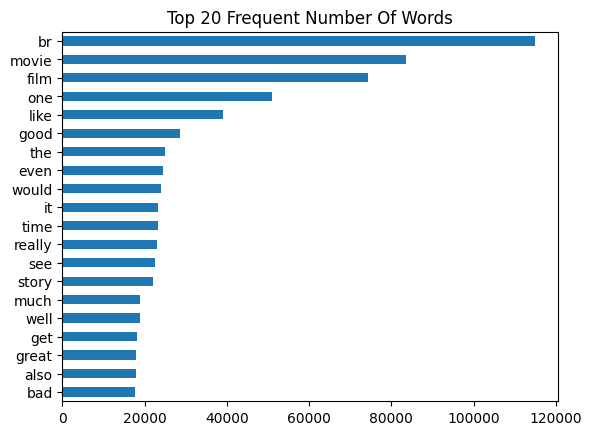

In [ ]:
most_freq_words = pd.Series(" ".join(text_cleaned['clean_review']).split()).value_counts()
most_freq_words.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Number Of Words")

In [ ]:
df = text_cleaned.copy()

In [ ]:
df['review'] = df.clean_review

# Logitstic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
RANDOM_STATE = 42

In [ ]:
# encode target variable for model to understand

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
df.head()


,review,sentiment,clean_review,tag_count,tags,sentiment_encoded
0,one reviewers mentioned watching oz episode h...,positive,one reviewers mentioned watching oz episode h...,6,"[br /, br /, br /, br /, br /, br /]",1
1,wonderful little production br br the filming ...,positive,wonderful little production br br the filming ...,6,"[br /, br /, br /, br /, br /, br /]",1
2,thought wonderful way spend time hot summer we...,positive,thought wonderful way spend time hot summer we...,4,"[br /, br /, br /, br /]",1
3,basically theres family little boy jake thinks...,negative,basically theres family little boy jake thinks...,6,"[br /, br /, br /, br /, br /, br /]",0
4,petter matteis love time money visually stunni...,positive,petter matteis love time money visually stunni...,8,"[br /, br /, br /, br /, br /, br /, br /, br /]",1


In [ ]:
# split the data in train test

X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment_encoded'].values,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
# extract features from text

vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [ ]:
# define model

log_model = LogisticRegression()

In [ ]:
# fit on train

log_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [ ]:
# evaluate model

test_preds = log_model.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.84
Precision on Test Set: 0.83
Recall on Test Set: 0.85
Accuracy on Test Set: 0.84
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4961
           1       0.83      0.85      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix:
[[4098  863]
 [ 755 4284]]


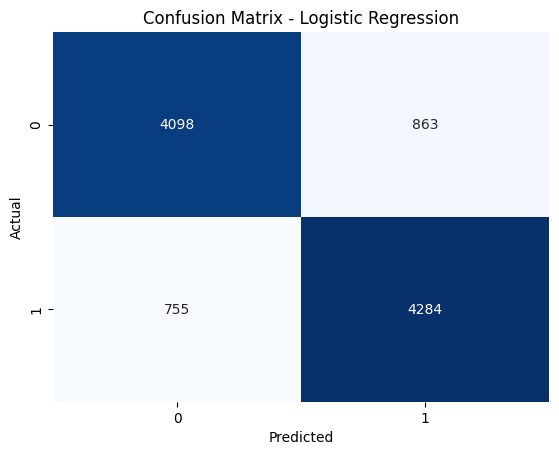

In [ ]:
# plot confusion matrix

conf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

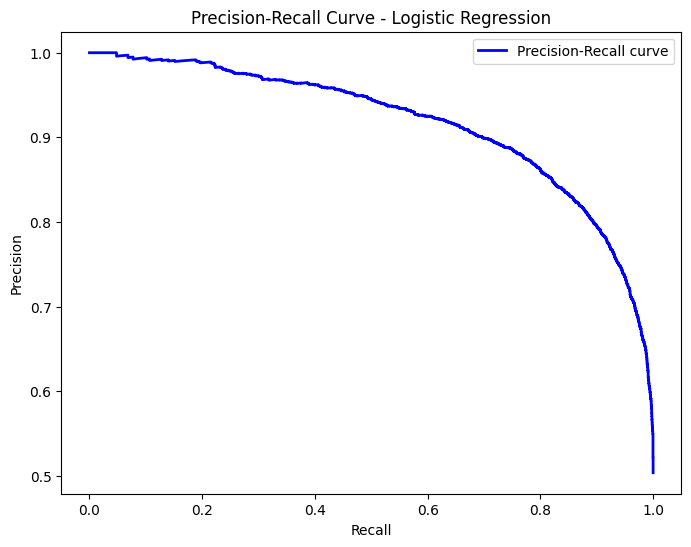

In [ ]:
# get precision recall curve

test_proba = log_model.predict_proba(X_test_tfidf)

precision, recall, _ = precision_recall_curve(y_test, test_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='best')
plt.show()

In [ ]:
log_model_metrics = {'model':"logistic_regression",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# SVM Model

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],          # Regularization parameter
#     'gamma': [0.01, 0.1, 1, 'auto'], # Kernel coefficient
# }

In [ ]:
## best params from previous run
params = {'C':0.1, 'gamma':0.1}

In [ ]:
svm_model = SVC(**params, kernel="rbf", random_state=RANDOM_STATE, probability=True)

In [ ]:
# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=svm_model,
#                            param_grid=param_grid,
#                            scoring='f1',cv=2, verbose=1, n_jobs=-1)

In [ ]:
# # Perform grid search
# grid_search.fit(X_train_tfidf, y_train)

In [ ]:
# grid_search.best_params_
# {'C':0.1, 'gamma':0.1}

In [ ]:
# best_svm_model = grid_search.best_estimator_

In [ ]:
# fit data on best model

svm_model.fit(X_train_tfidf, y_train)

SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

In [ ]:
svm_model

SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

In [ ]:
# evaluate model

test_preds = svm_model.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.83
Precision on Test Set: 0.80
Recall on Test Set: 0.87
Accuracy on Test Set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4961
           1       0.80      0.87      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[3899 1062]
 [ 680 4359]]


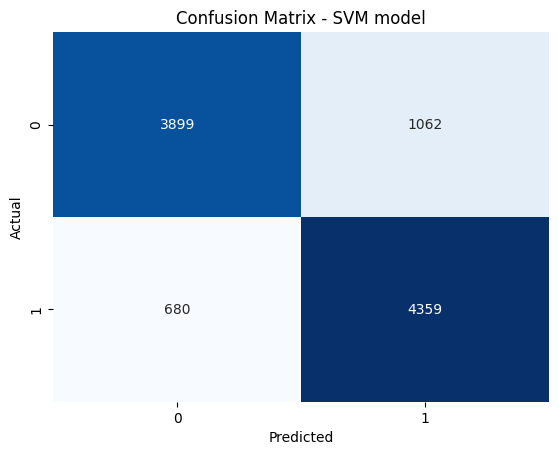

In [ ]:
# plot confusion matrix

conf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM model')
plt.show()

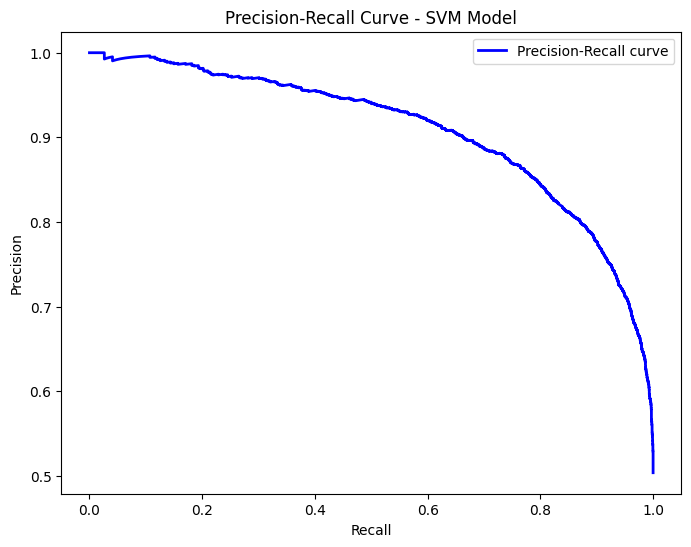

In [ ]:
# get precision recall curve

test_proba = svm_model.predict_proba(X_test_tfidf)

precision, recall, _ = precision_recall_curve(y_test, test_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model')
plt.legend(loc='best')
plt.show()

In [ ]:
svm_model_metrics = {'model':"svm_model",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# XGBoost Model

In [ ]:
# define model with best parameters

model_XGB = XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth = 3, objective='binary:logistic')

In [ ]:

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'gamma': [0, 0.1, 0.2],

# }

# # Create the XGBoost model
# model_XGB = XGBClassifier(objective='binary:logistic')

# # Create GridSearchCV object
# grid_search = GridSearchCV(model_XGB, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# # Perform grid search
# grid_result = grid_search.fit(X_train_tfidf, y_train)

# # Print the best parameters and corresponding accuracy
# print("Best Parameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

# # Get the best model
# best_model = grid_result.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test_tfidf)

# # Evaluate the best model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy on Test Set: {accuracy:.2f}')

# # Print classification report and confusion matrix for the best model
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

In [ ]:
# fit model
model_XGB.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# evaluate model

# Make predictions on the test set
test_preds = model_XGB.predict(X_test_tfidf)

f1score = f1_score(y_test, test_preds)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, test_preds)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, test_preds)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, test_preds)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

F1-Score on Test Set: 0.83
Precision on Test Set: 0.81
Recall on Test Set: 0.86
Accuracy on Test Set: 0.82
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      4961
           1       0.81      0.86      0.83      5039

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

Confusion Matrix:
[[3934 1027]
 [ 730 4309]]


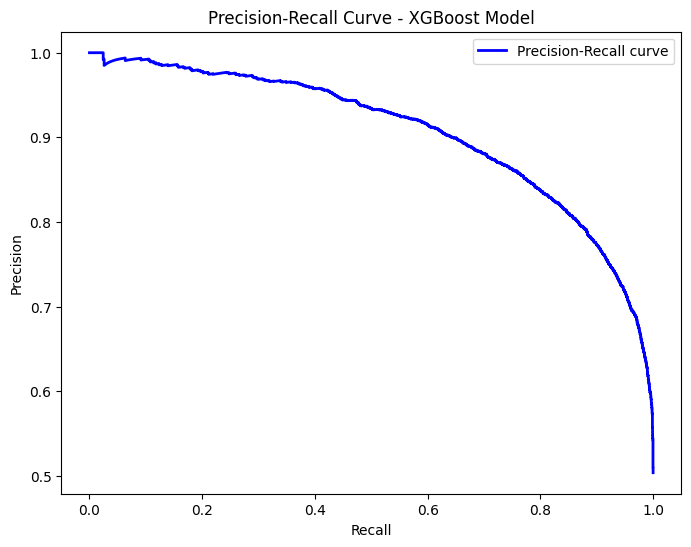

In [ ]:
from sklearn.metrics import precision_recall_curve

pred_proba = model_XGB.predict_proba(X_test_tfidf)
precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model')
plt.legend(loc='best')
plt.show()


# Deep Learning model

In [ ]:
df.head()

,review,sentiment,clean_review,tag_count,tags,sentiment_encoded
0,one reviewers mentioned watching oz episode h...,positive,one reviewers mentioned watching oz episode h...,6,"[br /, br /, br /, br /, br /, br /]",1
1,wonderful little production br br the filming ...,positive,wonderful little production br br the filming ...,6,"[br /, br /, br /, br /, br /, br /]",1
2,thought wonderful way spend time hot summer we...,positive,thought wonderful way spend time hot summer we...,4,"[br /, br /, br /, br /]",1
3,basically theres family little boy jake thinks...,negative,basically theres family little boy jake thinks...,6,"[br /, br /, br /, br /, br /, br /]",0
4,petter matteis love time money visually stunni...,positive,petter matteis love time money visually stunni...,8,"[br /, br /, br /, br /, br /, br /, br /, br /]",1


In [ ]:
# pad features

MAX_LENGTH = 400
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
df['padded_review_tokens'] = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(df['padded_review_tokens'], maxlen=MAX_LENGTH, padding='post', truncating='post')

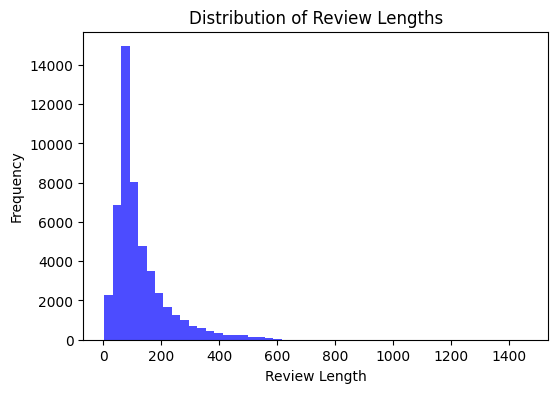

In [ ]:
# plot distribution of review length

df['review_length'] = df['padded_review_tokens'].apply(len)

# Plot the length of each review
plt.figure(figsize=(6, 4))
plt.hist(df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()



In [ ]:
# split data into train test

X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    df['sentiment_encoded'].values,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
# define model

mode_lstm = Sequential()
mode_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=MAX_LENGTH))
# early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1, restore_best_weights=True)
mode_lstm.add(LSTM(100, return_sequences=True))
mode_lstm.add(GlobalMaxPooling1D())
mode_lstm.add(Dense(64, activation='relu'))
mode_lstm.add(Dense(1, activation='sigmoid'))

mode_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

history = mode_lstm.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
1000/1000 [==============================] - 628s 626ms/step - loss: 0.3594 - auc: 0.9202 - val_loss: 0.2737 - val_auc: 0.9559
Epoch 2/3
1000/1000 [==============================] - 624s 624ms/step - loss: 0.1377 - auc: 0.9874 - val_loss: 0.3091 - val_auc: 0.9525
Epoch 3/3
1000/1000 [==============================] - 606s 607ms/step - loss: 0.0520 - auc: 0.9975 - val_loss: 0.4467 - val_auc: 0.9369


In [ ]:
mode_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           8821700   
                                                                 
 lstm (LSTM)                 (None, 400, 100)          60400     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8888629 (33.91 MB)
Trainable params: 8888629 (33.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# evaluate model

loss, accuracy = mode_lstm.evaluate(X_test, y_test)
print(f'Accuracy on Test Set: {accuracy:.2f}')

y_pred_DL = mode_lstm.predict(X_test)
y_pred_binary = (y_pred_DL > 0.5).astype(int)

f1score = f1_score(y_test, y_pred_binary)
print(f'F1-Score on Test Set: {f1score:.2f}')

pr_score = precision_score(y_test, y_pred_binary)
print(f'Precision on Test Set: {pr_score:.2f}')

rec_score = recall_score(y_test, y_pred_binary)
print(f'Recall on Test Set: {rec_score:.2f}')

acc_score = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy on Test Set: {acc_score:.2f}')


print(classification_report(y_test, y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

313/313 [==============================] - 35s 110ms/step - loss: 0.4229 - auc: 0.9409
Accuracy on Test Set: 0.94
313/313 [==============================] - 32s 101ms/step
F1-Score on Test Set: 0.88
Precision on Test Set: 0.87
Recall on Test Set: 0.89
Accuracy on Test Set: 0.88
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix:
[[4267  694]
 [ 547 4492]]


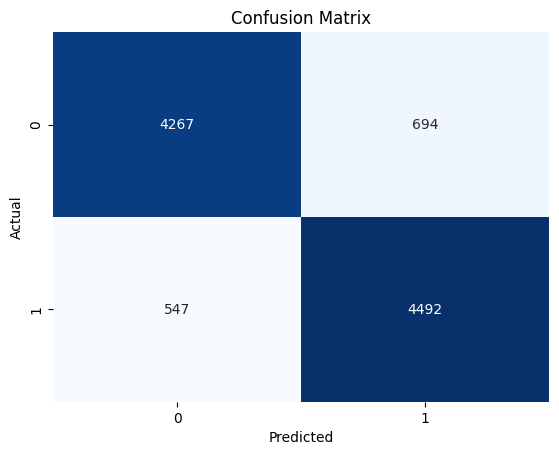

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

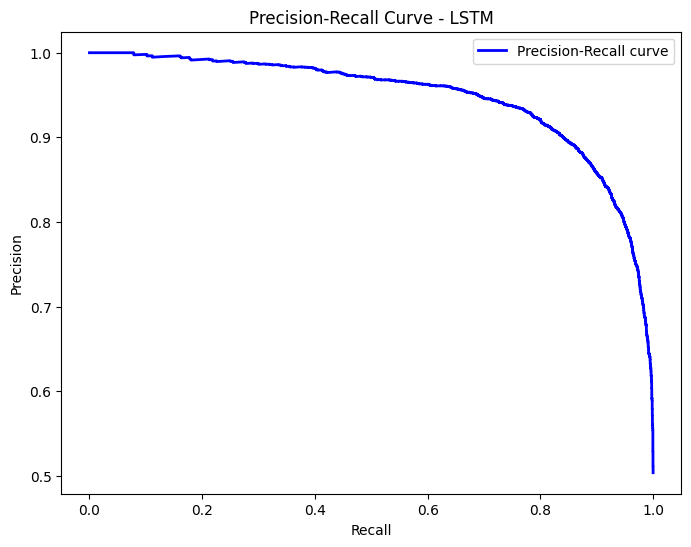

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_DL)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LSTM')
plt.legend(loc='best')
plt.show()

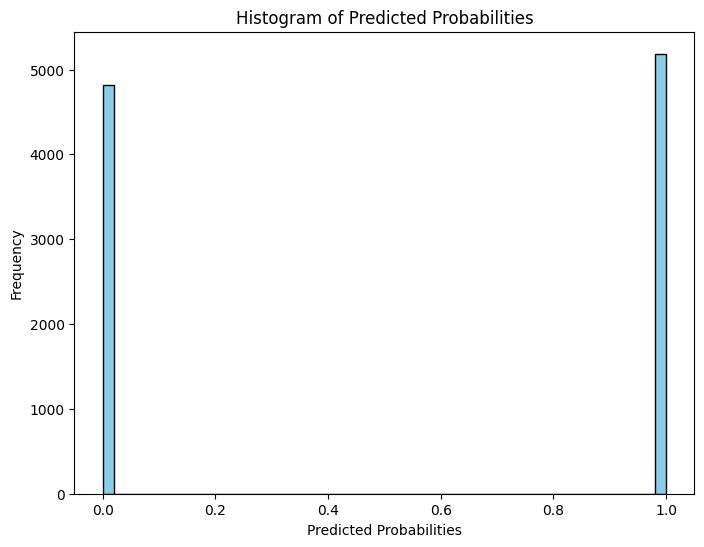

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y_pred_binary, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

In [ ]:
dl_model_metrics = {'model':"deep_learning",
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}

# results

In [ ]:
models = [log_model, svm_model, model_XGB]

In [ ]:
model_metrics_obj = []

In [ ]:
for model in models:
  preds = model.predict(X_test_tfidf)
  f1score = f1_score(y_test, preds)

  pr_score = precision_score(y_test, preds)
  rec_score = recall_score(y_test, preds)

  acc_score = accuracy_score(y_test, preds)

  model_metrics = {'model':model,
                    "f1_score":f1score,
                    "precision":pr_score,
                    "recall":rec_score,
                    "accuracy":acc_score}
  model_metrics_obj.append(model_metrics)

In [ ]:
results_df = pd.DataFrame(model_metrics_obj)

In [ ]:
results_df = results_df.append(dl_model_metrics, ignore_index=True)

In [ ]:
results_df.sort_values("f1_score", ascending=False)

,model,f1_score,precision,recall,accuracy
3,deep_learning,0.878631,0.866178,0.891447,0.8759
0,LogisticRegression(),0.841155,0.832330,0.850169,0.8382
1,"SVC(C=0.1, gamma=0.1, probability=True, random...",0.833461,0.804095,0.865053,0.8258
2,"XGBClassifier(base_score=None, booster=None, c...",0.830651,0.807534,0.855130,0.8243


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           8821700   
                                                                 
 lstm (LSTM)                 (None, 400, 100)          60400     
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8888629 (33.91 MB)
Trainable params: 8888629 (33.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
 models = [log_model, svm_model, model_XGB]

In [ ]:
prec_rec_df = pd.DataFrame()

for mod in models:
  print(f"Predicting for {mod} model")
  pred_proba = mod.predict_proba(X_test_tfidf)
  df_vals = pd.DataFrame({"model":mod,"true": y_test, "preds":pred_proba[:, 1]})
  prec_rec_df = pd.concat([prec_rec_df, df_vals])

Predicting for LogisticRegression() model
Predicting for SVC(C=0.1, gamma=0.1, probability=True, random_state=42) model
Predicting for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model


In [ ]:
X_test

array([[   12,   322, 43283, ...,     0,     0,     0],
       [   32,   610,   163, ...,     0,     0,     0],
       [    3,   842,   110, ...,     0,     0,     0],
       ...,
       [  330, 64887,    81, ...,     0,     0,     0],
       [  131,    26,    56, ...,     0,     0,     0],
       [  108,  8482,    63, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_pred_DL = model_lstm.predict(X_test)

313/313 [==============================] - 37s 119ms/step


array([9.9852151e-01, 9.9981821e-01, 6.1681401e-04, ..., 9.9496490e-01,
       7.0526996e-03, 6.0560358e-01], dtype=float32)

In [ ]:
df_vals = pd.DataFrame({"model":model_lstm,"true": y_test, "preds":y_pred_DL.flatten()})

In [ ]:
prec_rec_df = pd.concat([prec_rec_df, df_vals])

In [ ]:
# get model name as text
prec_rec_df.model = [str(i).split("(")[0] for i in prec_rec_df.model]
prec_rec_df.model = [str(i).split(".")[0] for i in prec_rec_df.model]
prec_rec_df.model = np.where(prec_rec_df.model.isin(['<keras']), "LSTM", prec_rec_df.model)

In [ ]:
grp_df = prec_rec_df.groupby("model")

In [ ]:
grp_df.get_group(group)

,model,true,preds
0,XGBClassifier,1,0.343057
1,XGBClassifier,1,0.773098
2,XGBClassifier,0,0.168229
3,XGBClassifier,1,0.962868
4,XGBClassifier,0,0.158963
...,...,...,...
9995,XGBClassifier,0,0.127053
9996,XGBClassifier,1,0.777840
9997,XGBClassifier,1,0.453413
9998,XGBClassifier,0,0.390676


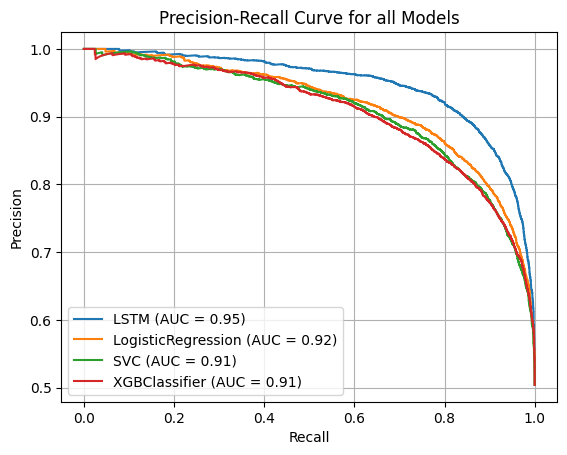

In [ ]:
for group in grp_df.groups:
  tmp_df = grp_df.get_group(group)
  precision, recall, thresholds = precision_recall_curve(tmp_df['true'], tmp_df['preds'])
  area = auc(recall, precision)

  plt.plot(recall, precision, label=f'{group} (AUC = {area:.2f})')
  plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for all Models')
plt.grid(True)